In [ ]:
#%tensorflow_version 1.x

In [ ]:
#import necessary libraries

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
np.random.seed(2)
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
#from tensorflow.keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout
from tensorflow.keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping
from keras.preprocessing import image
from keras.optimizers import Adam


In [ ]:
import tensorflow as tf
from tensorflow.python import keras

In [ ]:
#import tensorflow
#print(tensorflow.__version__)

In [ ]:
from PIL import Image, ImageChops, ImageEnhance
import os
import itertools

In [ ]:
def convert_to_ela_image(path, quality):
    temp_filename = 'temp_file_name.jpg'
    ela_filename = 'temp_ela.png'
    
    image = Image.open(path).convert('RGB')
    image.save(temp_filename, 'JPEG', quality = quality)
    temp_image = Image.open(temp_filename)
    
    ela_image = ImageChops.difference(image, temp_image)
    
    extrema = ela_image.getextrema()
    max_diff = max([ex[1] for ex in extrema])
    if max_diff == 0:
        max_diff = 1
    scale = 255.0 / max_diff
    
    ela_image = ImageEnhance.Brightness(ela_image).enhance(scale)
    
    return ela_image

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


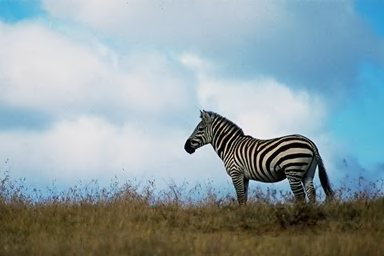

In [ ]:
real_image_path = '/content/gdrive/MyDrive/DATASET/Au/Au_ani_00001.jpg'
Image.open(real_image_path)
#from keras.preprocessing import image
# and use 
# image.ImageDataGenerator()
# image.load_img(

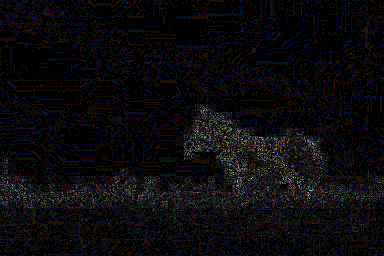

In [ ]:
convert_to_ela_image(real_image_path, 90)

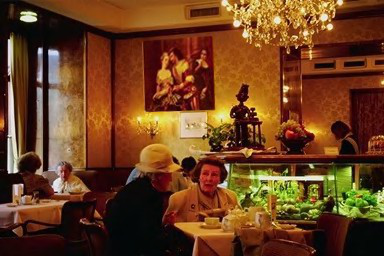

In [ ]:
fake_image_path = '/content/gdrive/MyDrive/DATASET/Tp/Tp_D_CND_S_N_ind00078_ind00077_00476.resaved.jpg'
Image.open(fake_image_path)

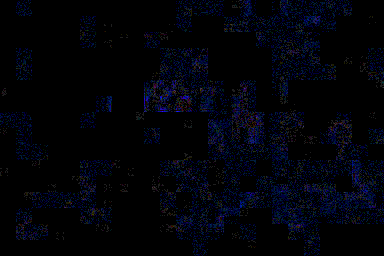

In [ ]:
convert_to_ela_image(fake_image_path, 90)

In [ ]:
image_size = (128, 128)

In [ ]:
def prepare_image(image_path):
    return np.array(convert_to_ela_image(image_path, 90).resize(image_size)).flatten() / 255.0

In [ ]:
X = [] # ELA converted images
Y = [] # 0 for fake, 1 for real
#Au is Authentic pics
#Tp is Tampered pics

In [ ]:
import random
path = '/content/gdrive/MyDrive/DATASET/Au/'
for dirname, _, filenames in os.walk(path):
    for filename in filenames:
        if filename.endswith('jpg') or filename.endswith('png'):
            full_path = os.path.join(dirname, filename)
            X.append(prepare_image(full_path))
            Y.append(1)
            if len(Y) % 500 == 0:
                print(f'Processing {len(Y)} images')

random.shuffle(X)
X = X[:2100]
Y = Y[:2100]
print(len(X), len(Y))

111 111


In [ ]:
path = '/content/gdrive/MyDrive/DATASET/Tp/'
for dirname, _, filenames in os.walk(path):
    for filename in filenames:
        if filename.endswith('jpg') or filename.endswith('png'):
            full_path = os.path.join(dirname, filename)
            X.append(prepare_image(full_path))
            Y.append(0)
            if len(Y) % 500 == 0:
                print(f'Processing {len(Y)} images')

print(len(X), len(Y))

199 199


In [ ]:
X = np.array(X)
Y = to_categorical(Y, 2)
X = X.reshape(-1, 128, 128, 3)

In [ ]:
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size = 0.2, random_state=5)
X = X.reshape(-1,1,1,1)
print(len(X_train), len(Y_train))
print(len(X_val), len(Y_val))

159 159
40 40


In [ ]:
def build_model():
    model = Sequential()
    model.add(Conv2D(filters = 32, kernel_size = (5, 5), padding = 'valid', activation = 'relu', input_shape = (128, 128, 3)))
    model.add(Conv2D(filters = 32, kernel_size = (5, 5), padding = 'valid', activation = 'relu', input_shape = (128, 128, 3)))
    model.add(MaxPool2D(pool_size = (2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(256, activation = 'relu'))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation = 'softmax'))
    return model

In [ ]:
model = build_model()
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 124, 124, 32)      2432      
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 120, 120, 32)      25632     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 60, 60, 32)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 60, 60, 32)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 115200)            0         
_________________________________________________________________
dense_5 (Dense)              (None, 256)               29491456  
_________________________________________________________________
dropout_6 (Dropout)          (None, 256)              

In [ ]:
epochs = 30
batch_size = 32

In [ ]:
init_lr = 1e-4
optimizer = Adam(learning_rate = init_lr, decay = init_lr/epochs)
#optimizer =keras.optimizers.Adam(learning_rate = init_lr, decay = init_lr/epochs)

In [ ]:

model.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = ['accuracy'])

In [ ]:
early_stopping = EarlyStopping(monitor = 'val_accuracy',
                              min_delta = 0,
                              patience = 2,
                              verbose = 0,
                              mode = 'auto')

In [ ]:
hist = model.fit(X_train,
                 Y_train,
                 batch_size = batch_size,
                 epochs = epochs,
                validation_data = (X_val, Y_val),
                callbacks = [early_stopping])

Train on 159 samples, validate on 40 samples
Epoch 1/30
159/159 [==============================] - 16s 101ms/step - loss: 0.6633 - accuracy: 0.5597 - val_loss: 0.7000 - val_accuracy: 0.5250
Epoch 2/30
159/159 [==============================] - 16s 100ms/step - loss: 0.6094 - accuracy: 0.7987 - val_loss: 0.6922 - val_accuracy: 0.7250
Epoch 3/30
159/159 [==============================] - 16s 100ms/step - loss: 0.5448 - accuracy: 0.8679 - val_loss: 0.6433 - val_accuracy: 0.7250
Epoch 4/30
159/159 [==============================] - 16s 100ms/step - loss: 0.4788 - accuracy: 0.8239 - val_loss: 0.6205 - val_accuracy: 0.7000


In [ ]:
hist = model.fit(X_train,
                 Y_train,
                 batch_size = batch_size,
                 epochs = epochs,
                validation_data = (X_val, Y_val),
                callbacks = [early_stopping])

Train on 159 samples, validate on 40 samples
Epoch 1/30
159/159 [==============================] - 16s 100ms/step - loss: 0.4034 - accuracy: 0.8805 - val_loss: 0.6473 - val_accuracy: 0.7000
Epoch 2/30
159/159 [==============================] - 16s 100ms/step - loss: 0.3516 - accuracy: 0.8742 - val_loss: 0.5929 - val_accuracy: 0.7000
Epoch 3/30
159/159 [==============================] - 16s 99ms/step - loss: 0.2856 - accuracy: 0.9182 - val_loss: 0.6158 - val_accuracy: 0.7750
Epoch 4/30
159/159 [==============================] - 16s 100ms/step - loss: 0.2443 - accuracy: 0.9560 - val_loss: 0.5805 - val_accuracy: 0.7750
Epoch 5/30
159/159 [==============================] - 16s 99ms/step - loss: 0.2022 - accuracy: 0.9308 - val_loss: 0.6039 - val_accuracy: 0.8000
Epoch 6/30
159/159 [==============================] - 16s 100ms/step - loss: 0.1640 - accuracy: 0.9560 - val_loss: 0.6935 - val_accuracy: 0.7500
Epoch 7/30
159/159 [==============================] - 16s 99ms/step - loss: 0.1569 - ac

In [ ]:

model.save('model_casia_run1.h5')

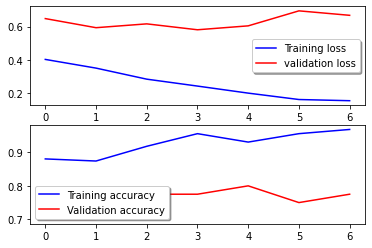

In [ ]:
# Plot the loss and accuracy curves for training and validation 
fig, ax = plt.subplots(2,1)
ax[0].plot(hist.history['loss'], color='b', label="Training loss")
ax[0].plot(hist.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(hist.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(hist.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

[[0.6580897  0.34191033]
 [0.10216387 0.89783615]
 [0.02360015 0.9763999 ]
 [0.41293457 0.58706546]
 [0.7176646  0.28233543]
 [0.95774096 0.04225901]
 [0.92941934 0.07058063]
 [0.2002956  0.7997044 ]
 [0.12225712 0.8777429 ]
 [0.97251004 0.02748997]
 [0.9205434  0.07945661]
 [0.92248774 0.0775123 ]
 [0.12513845 0.87486154]
 [0.08270478 0.9172952 ]
 [0.17055559 0.82944435]
 [0.2743588  0.7256412 ]
 [0.05720806 0.94279194]
 [0.26184717 0.73815286]
 [0.976397   0.02360301]
 [0.96584475 0.03415528]
 [0.60675585 0.39324415]
 [0.92699605 0.07300395]
 [0.16044176 0.83955824]
 [0.8386141  0.16138588]
 [0.22745708 0.77254295]
 [0.4522798  0.54772013]
 [0.94942755 0.05057253]
 [0.936952   0.06304806]
 [0.04106028 0.95893973]
 [0.01596654 0.98403347]
 [0.5440252  0.4559748 ]
 [0.987495   0.01250498]
 [0.6853803  0.31461966]
 [0.02780616 0.9721939 ]
 [0.00302302 0.996977  ]
 [0.36622205 0.6337779 ]
 [0.98316944 0.01683057]
 [0.95290774 0.04709222]
 [0.95584714 0.04415287]
 [0.02230762 0.9776923 ]]

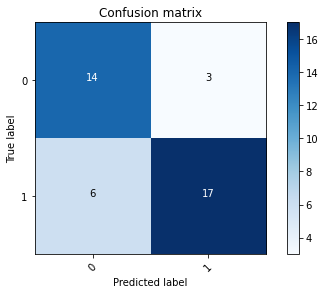

In [ ]:
# Predict the values from the validation dataset
Y_pred = model.predict(X_val)
print(Y_pred)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(Y_val,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(2))

In [ ]:
class_names = ['fake', 'real']

In [ ]:
real_image_path = '/content/gdrive/MyDrive/DATASET/Au/Au_ani_00001.jpg'
image = prepare_image(real_image_path)
image = image.reshape(-1, 128, 128, 3)
y_pred = model.predict(image)
y_pred_class = np.argmax(y_pred, axis = 1)[0]
print(f'Class: {class_names[y_pred_class]} Confidence: {np.amax(y_pred) * 100:0.2f}')

Class: fake Confidence: 92.25


In [ ]:
real_image_path = '/content/gdrive/MyDrive/DATASET/Tp/Tp_D_CND_S_N_ind00078_ind00077_00476.resaved.jpg'
image = prepare_image(real_image_path)
image = image.reshape(-1, 128, 128, 3)
y_pred = model.predict(image)
y_pred_class = np.argmax(y_pred, axis = 1)[0]
print(f'Class: {class_names[y_pred_class]} Confidence: {np.amax(y_pred) * 100:0.2f}')


Class: fake Confidence: 98.75


In [ ]:
fake_image = os.listdir('/content/gdrive/MyDrive/DATASET/Tp/')
correct = 0
total = 0
for file_name in fake_image:
    if file_name.endswith('jpg') or filename.endswith('png'):
        fake_image_path = os.path.join('/content/gdrive/MyDrive/DATASET/Tp/', file_name)
        image = prepare_image(fake_image_path)
        image = image.reshape(-1, 128, 128, 3)
        y_pred = model.predict(image)
        y_pred_class = np.argmax(y_pred, axis = 1)[0]
        total += 1
        if y_pred_class == 0:
            correct += 1
#             print(f'Class: {class_names[y_pred_class]} Confidence: {np.amax(y_pred) * 100:0.2f}')

In [ ]:
print(f'Total: {total}, Correct: {correct}, Acc: {correct / total * 100.0}')

Total: 88, Correct: 74, Acc: 84.0909090909091


In [ ]:
real_image = os.listdir('/content/gdrive/MyDrive/DATASET/Au/')
correct_r = 0
total_r = 0
for file_name in real_image:
    if file_name.endswith('jpg') or filename.endswith('png'):
        real_image_path = os.path.join('/content/gdrive/MyDrive/DATASET/Au/', file_name)
        image = prepare_image(real_image_path)
        image = image.reshape(-1, 128, 128, 3)
        y_pred = model.predict(image)
        y_pred_class = np.argmax(y_pred, axis = 1)[0]
        total_r += 1
        if y_pred_class == 1:
            correct_r += 1
           # print(f'Class: {class_names[y_pred_class]} Confidence: {np.amax(y_pred) * 100:0.2f}')

In [ ]:
correct += correct_r
total += total_r
print(f'Total: {total_r}, Correct: {correct_r}, Acc: {correct_r / total_r * 100.0}')
print(f'Total: {total}, Correct: {correct}, Acc: {correct / total * 100.0}')

Total: 111, Correct: 101, Acc: 90.990990990991
Total: 199, Correct: 175, Acc: 87.93969849246231


In [ ]:
real_image_path = '/content/gdrive/MyDrive/DATASET/Au/111.jpg'
image = prepare_image(real_image_path)
image = image.reshape(-1, 128, 128, 3)
y_pred = model.predict(image)
y_pred_class = np.argmax(y_pred, axis = 1)[0]
print(f'Class: {class_names[y_pred_class]} Confidence: {np.amax(y_pred) * 100:0.2f}')

Class: real Confidence: 69.31


In [ ]:
real_image_path = '/content/gdrive/MyDrive/DATASET/Tp/Tp_D_CND_M_N_art00076_art00077_10289.saved.jpg'
image = prepare_image(real_image_path)
image = image.reshape(-1, 128, 128, 3)
y_pred = model.predict(image)
y_pred_class = np.argmax(y_pred, axis = 1)[0]
print(f'Class: {class_names[y_pred_class]} Confidence: {np.amax(y_pred) * 100:0.2f}')

Class: fake Confidence: 62.88


In [ ]:
real_image_path = '/content/gdrive/MyDrive/DATASET/Tp/flo.jpg'
image = prepare_image(real_image_path)
image = image.reshape(-1, 128, 128, 3)
y_pred = model.predict(image)
y_pred_class = np.argmax(y_pred, axis = 1)[0]
print(f'Class: {class_names[y_pred_class]} Confidence: {np.amax(y_pred) * 100:0.2f}')

Class: fake Confidence: 85.87


In [ ]:
real_image_path = '/content/gdrive/MyDrive/DATASET/Au/Au_ani_00052.jpg'
image = prepare_image(real_image_path)
image = image.reshape(-1, 128, 128, 3)
y_pred = model.predict(image)
y_pred_class = np.argmax(y_pred, axis = 1)[0]
print(f'Class: {class_names[y_pred_class]} Confidence: {np.amax(y_pred) * 100:0.2f}')

Class: real Confidence: 63.48


In [ ]:
real_image_path = '/content/gdrive/MyDrive/kitten.jpg'
image = prepare_image(real_image_path)
image = image.reshape(-1, 128, 128, 3)
y_pred = model.predict(image)
y_pred_class = np.argmax(y_pred, axis = 1)[0]
print(f'Class: {class_names[y_pred_class]} Confidence: {np.amax(y_pred) * 100:0.2f}')

Class: fake Confidence: 77.35


In [ ]:
real_image_path = '/content/gdrive/MyDrive/11.jpg'
image = prepare_image(real_image_path)
image = image.reshape(-1, 128, 128, 3)
y_pred = model.predict(image)
y_pred_class = np.argmax(y_pred, axis = 1)[0]
print(f'Class: {class_names[y_pred_class]} Confidence: {np.amax(y_pred) * 100:0.2f}')

Class: real Confidence: 61.36


In [ ]:
real_image_path = '/content/gdrive/MyDrive/mmk.jpg'
image = prepare_image(real_image_path)
image = image.reshape(-1, 128, 128, 3)
y_pred = model.predict(image)
y_pred_class = np.argmax(y_pred, axis = 1)[0]
print(f'Class: {class_names[y_pred_class]} Confidence: {np.amax(y_pred) * 100:0.2f}')

Class: real Confidence: 77.09


In [ ]:
real_image_path = '/content/gdrive/MyDrive/kitten.jpg'
image = prepare_image(real_image_path)
image = image.reshape(-1, 128, 128, 3)
y_pred = model.predict(image)
y_pred_class = np.argmax(y_pred, axis = 1)[0]
print(f'Class: {class_names[y_pred_class]} Confidence: {np.amax(y_pred) * 100:0.2f}')

Class: fake Confidence: 77.35


In [ ]:
real_image_path = '/content/gdrive/MyDrive/kitten1.jpg'
image = prepare_image(real_image_path)
image = image.reshape(-1, 128, 128, 3)
y_pred = model.predict(image)
y_pred_class = np.argmax(y_pred, axis = 1)[0]
print(f'Class: {class_names[y_pred_class]} Confidence: {np.amax(y_pred) * 100:0.2f}')

Class: real Confidence: 83.31


In [ ]:
real_image_path = '/content/gdrive/MyDrive/kitten1.jpg'
image = prepare_image(real_image_path)
image = image.reshape(-1, 128, 128, 3)
y_pred = model.predict(image)
y_pred_class = np.argmax(y_pred, axis = 1)[0]
print(f'Class: {class_names[y_pred_class]} Confidence: {np.amax(y_pred) * 100:0.2f}')

Class: real Confidence: 83.31
